In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from ase.io import read
import torch
from tqdm import tqdm
from glob import glob
from pathlib import Path
from itertools import product
from mace import data, tools
from mace.tools import torch_geometric
from mace.tools.torch_tools import to_numpy
from contextlib import contextmanager


sns.set_theme(style="whitegrid")

In [3]:
test_files = sorted(glob("/home/hatemh/BOTNet-datasets/dataset_3BPA/test_*"))
checkpoint_files = sorted(glob("/home/hatemh/mace/experiments/checkpoints/*.model"))
num_tests = len(test_files)
num_checkpoints = len(checkpoint_files)
total_combinations = num_tests * num_checkpoints
total_combinations

96

In [4]:
z_table = tools.utils.AtomicNumberTable([1, 6, 7, 8])
r_max = 5.0
device = "cuda"

In [5]:
def parse_clip_grad(name: str):
    part = list(filter(lambda x: x.startswith("cg"), name.split("_")))

    if len(part) == 0:
        return -1

    return float(part[0].split("-")[-1])


def parse_loss_scale(name: str):
    part = list(filter(lambda x: x.startswith("ls"), name.split("_")))

    if len(part) == 0:
        return 1.0

    return float(part[0].split("-")[-1])


def parse_values(checkpoint_file: str):
    name = Path(checkpoint_file).stem
    seed = int(name.split("-")[-1])
    dtype = "float32" if name.find("fp64") == -1 else "float64"
    clip_grad = parse_clip_grad(name)
    loss_scale = parse_loss_scale(name)
    return {
        "seed": seed,
        "dtype": dtype,
        "clip_grad": clip_grad,
        "loss_scale": loss_scale,
    }


def make_loader(atoms_list):
    configs = data.utils.config_from_atoms_list(atoms_list)
    dataset = [
        data.AtomicData.from_config(c, z_table=z_table, cutoff=r_max) for c in configs
    ]
    loader = torch_geometric.dataloader.DataLoader(
        dataset=dataset, batch_size=32, shuffle=False, drop_last=False
    )
    return loader


@contextmanager
def default_dtype(dtype: torch.dtype):
    init = torch.get_default_dtype()
    torch.set_default_dtype(dtype)
    yield
    torch.set_default_dtype(init)


def eval_model(checkpoint_file: str, test_file: str, device: str = device):
    model = torch.load(checkpoint_file)
    model.to(device)
    model_dtype = {p.dtype for p in model.parameters()}.pop()

    with default_dtype(model_dtype):
        atoms_list = read(test_file, index=":")
        loader = make_loader(atoms_list)
        errors = []

        for batch in tqdm(loader):
            batch = batch.to(device)
            target = to_numpy(batch.energy)
            output = model(batch.to_dict())
            pred = to_numpy(output["energy"])
            errors.append(np.abs(target - pred))
        
    del model
    del loader
    torch.cuda.empty_cache()
    
    errors = 1e3 * np.concatenate(errors, axis=0)
        
    
    return {
        **parse_values(checkpoint_file),
        "dataset": Path(test_file).stem,
        "mae (meV)": np.mean(errors),
        "rmse (meV)": np.sqrt(np.mean(errors**2)),
    }

In [6]:
records = [
    eval_model(cf, tf)
    for cf, tf in tqdm(product(checkpoint_files, test_files), total=total_combinations)
]
df = pd.DataFrame(records)
df

100%|██████████| 96/96 [49:33<00:00, 30.97s/it]


,seed,dtype,clip_grad,loss_scale,dataset,mae (meV),rmse (meV)
0,1702,float32,10.0,1.0,test_1200K,33.590279,47.956287
1,1702,float32,10.0,1.0,test_300K,2.469199,3.795256
2,1702,float32,10.0,1.0,test_600K,7.780527,12.153957
3,1702,float32,10.0,1.0,test_dih,13.505303,36.726757
4,285,float32,10.0,1.0,test_1200K,44.373100,61.470211
...,...,...,...,...,...,...,...
91,285,float32,-1.0,1.0,test_dih,6.344122,15.541770
92,43,float32,-1.0,1.0,test_1200K,25.081997,35.635929
93,43,float32,-1.0,1.0,test_300K,2.795695,3.890713
94,43,float32,-1.0,1.0,test_600K,7.028692,11.347771


In [9]:
df.to_parquet("eval_mace_sweep.parquet")

In [8]:
sweep_results = df.groupby(["dtype", "clip_grad", "loss_scale", "dataset"])["rmse (meV)"].describe()
sweep_results.sort_values(by=["mean"])

count       mean        std  \
dtype   clip_grad loss_scale dataset                                   
float64 -1.0      1000.0     test_300K     3.0   3.148797   0.230034   
                  1.0        test_300K     3.0   3.349013   0.273651   
float32 -1.0      1.0        test_300K     3.0   3.442834   0.563800   
                  1000.0     test_300K     3.0   3.493814   0.626072   
float64  10.0     1.0        test_300K     3.0   3.916364   0.397720   
float32  10.0     1.0        test_300K     3.0   4.736060   1.271212   
float64 -1.0      1.0        test_dih      3.0  10.743905   1.457659   
                  1000.0     test_dih      3.0  10.823023   1.401112   
float32 -1.0      1.0        test_600K     3.0  10.866991   0.661116   
float64 -1.0      1000.0     test_600K     3.0  10.938372   0.234655   
float32 -1.0      1000.0     test_600K     3.0  10.976325   0.765837   
float64 -1.0      1.0        test_600K     3.0  11.015477   0.308382   
         10.0     1.0        test_600K     3.0  11.867775   0.437681   
float32  10.0     1.0        test_600K     3.0  12.637782   0.524174   
        -1.0      1.0        test_dih      3.0  15.023447   3.365776   
                  1000.0     test_dih      3.0  15.219210   3.576130   
         10.0     1000.0     test_300K     3.0  20.417852   9.711743   
                             test_600K     3.0  26.533991   7.532442   
float64  10.0     1000.0     test_300K     3.0  28.337606  15.089569   
                  1.0        test_dih      3.0  30.024233   2.477730   
                  1000.0     test_600K     3.0  33.231421  13.677692   
float32  10.0     1.0        test_dih      3.0  33.952651   3.529052   
float64 -1.0      1.0        test_1200K    3.0  34.166128   3.489461   
                  1000.0     test_1200K    3.0  34.255437   3.282056   
float32 -1.0      1000.0     test_1200K    3.0  34.853329   1.115926   
                  1.0        test_1200K    3.0  35.159846   0.936441   
         10.0     1000.0     test_dih      3.0  51.614075   4.762899   
float64  10.0     1.0        test_1200K    3.0  52.066380   9.292152   
                  1000.0     test_dih      3.0  54.500875  12.019009   
float32  10.0     1.0        test_1200K    3.0  58.284536   9.160720   
                  1000.0     test_1200K    3.0  87.276721  16.536222   
float64  10.0     1000.0     test_1200K    3.0  88.473400  12.169870   

                                               min        25%        50%  \
dtype   clip_grad loss_scale dataset                                       
float64 -1.0      1000.0     test_300K    2.977336   3.018087   3.058838   
                  1.0        test_300K    3.188920   3.191025   3.193130   
float32 -1.0      1.0        test_300K    2.809720   3.218894   3.628068   
                  1000.0     test_300K    2.799941   3.232495   3.665048   
float64  10.0     1.0        test_300K    3.506245   3.724346   3.942447   
float32  10.0     1.0        test_300K    3.795256   4.012969   4.230683   
float64 -1.0      1.0        test_dih     9.639760   9.917774  10.195787   
                  1000.0     test_dih     9.906863  10.016574  10.126284   
float32 -1.0      1.0        test_600K   10.113071  10.626602  11.140132   
float64 -1.0      1000.0     test_600K   10.771174  10.804247  10.837319   
float32 -1.0      1000.0     test_600K   10.094882  10.725138  11.355394   
float64 -1.0      1.0        test_600K   10.809333  10.838215  10.867097   
         10.0     1.0        test_600K   11.583658  11.615760  11.647863   
float32  10.0     1.0        test_600K   12.153957  12.359351  12.564744   
        -1.0      1.0        test_dih    11.428576  13.485173  15.541770   
                  1000.0     test_dih    11.239540  13.747224  16.254908   
         10.0     1000.0     test_300K    9.433844  16.693124  23.952404   
                             test_600K   18.158335  23.424699  28.691063   
float64  10.0     1000.0     test_300K   11.184347  22.724586  34.264825

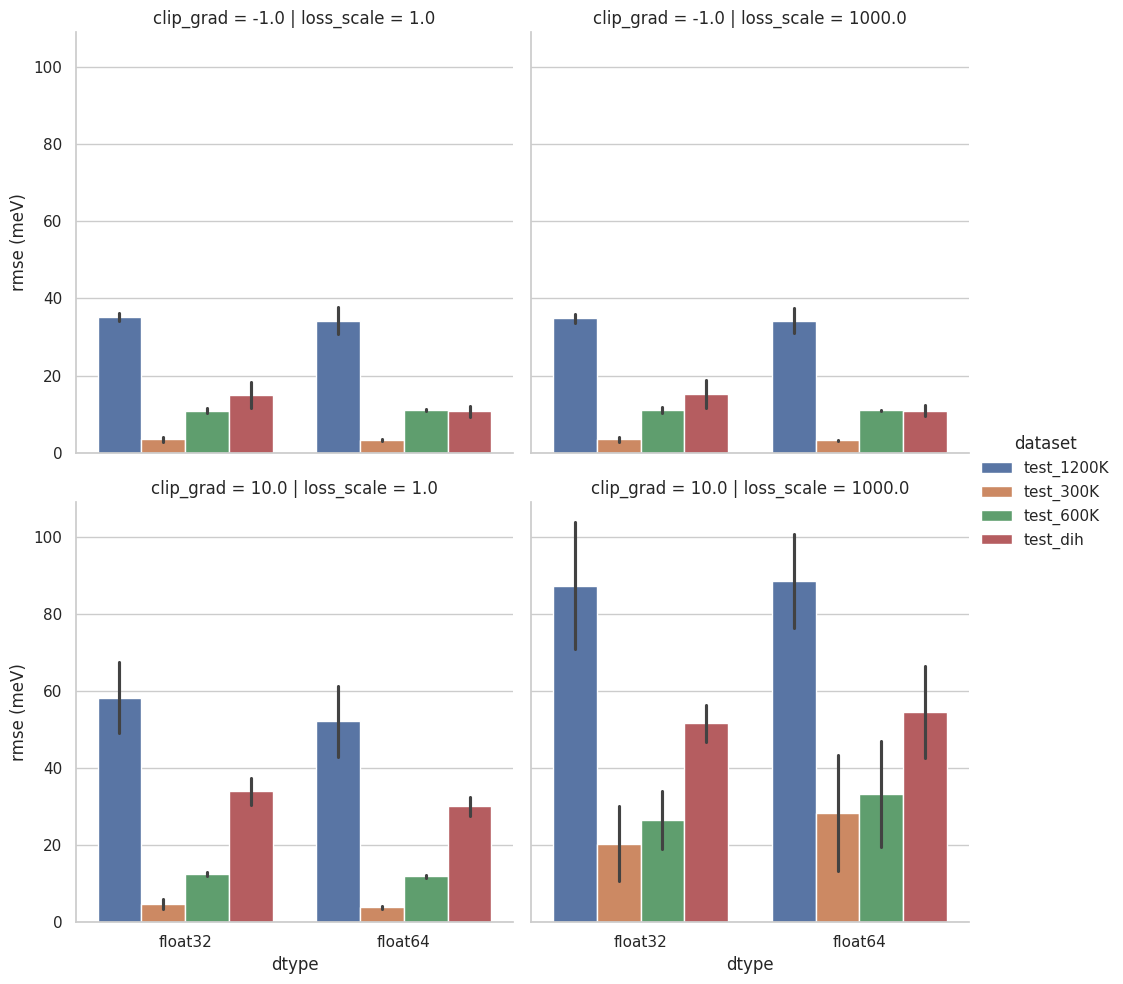

In [10]:
df = pd.read_parquet("eval_mace_sweep.parquet")
sns.catplot(
    data=df,
    x="dtype",
    y="rmse (meV)",
    col="loss_scale",
    row="clip_grad",
    hue="dataset",
    kind="bar",
    errorbar="sd",
)

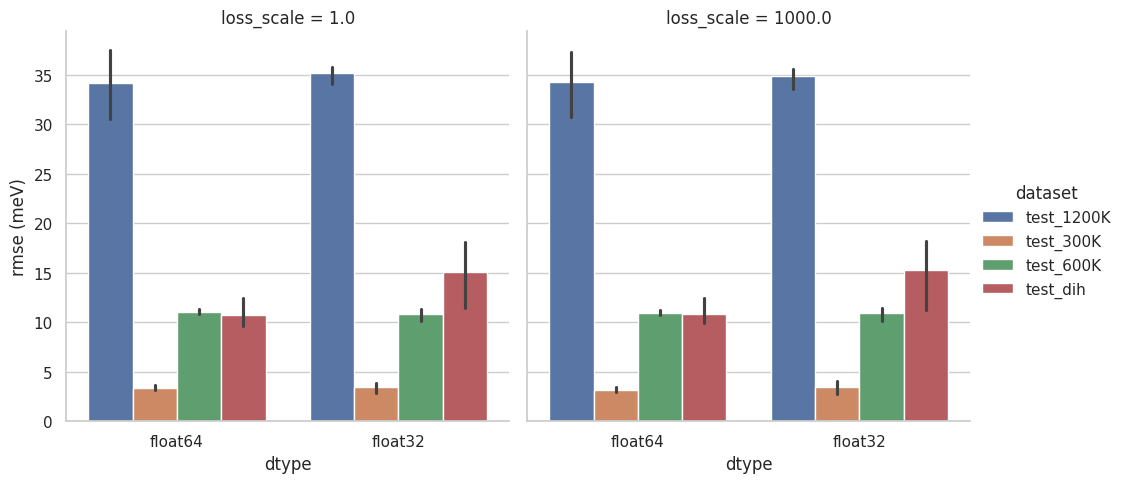

In [11]:
mask = (df["clip_grad"] == -1)
sns.catplot(data=df[mask], x="dtype", y="rmse (meV)", hue="dataset", col="loss_scale", kind="bar")

In [12]:
dataset = read("/home/hatemh/BOTNet-datasets/dataset_3BPA/test_dih.xyz", index=":")

alpha, beta, gamma = np.stack([d.info["dihedrals"] for d in dataset]).T
mask = (alpha == 71) & (beta == 120)
subset = [d for d, tf in zip(dataset, mask) if tf]
len(subset)

50

<Axes: >

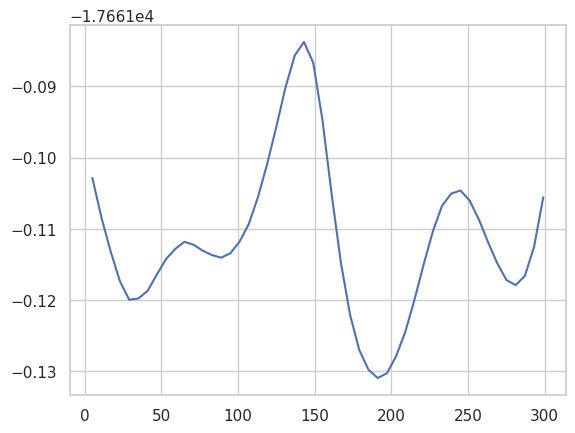

In [13]:
Eref = np.stack([d.info["energy"] for d in subset])
sns.lineplot(x=gamma[mask], y=Eref)

In [15]:
def eval_slice(checkpoint_file: str, device: str = device):
    model = torch.load(checkpoint_file)
    model.to(device)
    model_dtype = {p.dtype for p in model.parameters()}.pop()

    with default_dtype(model_dtype):
        loader = make_loader(subset)
        preds = []
        errors = []

        for batch in tqdm(loader):
            batch = batch.to(device)
            target = to_numpy(batch.energy)
            output = model(batch.to_dict())
            pred = to_numpy(output["energy"])
            preds.append(pred)
            errors.append(np.abs(target - pred))
        
    del model
    del loader
    torch.cuda.empty_cache()
    
    errors = 1e3 * np.concatenate(errors, axis=0)
    results = pd.DataFrame({"alpha": alpha[mask],
        "beta": beta[mask],
        "gamma": gamma[mask],
        "E predicted (eV)": np.concatenate(preds, axis=0)})

    
    for k, v in parse_values(checkpoint_file).items():
        results[k] = v
    
    return results

In [16]:
checkpoints = glob("checkpoints/model_fp64_run*.model") + glob("checkpoints/model_run*.model")
slice_df = pd.concat([eval_slice(c) for c in checkpoints])
slice_df.head()

100%|██████████| 2/2 [00:00<00:00,  4.29it/s]


,alpha,beta,gamma,E predicted (eV),seed,dtype,clip_grad,loss_scale
0,71.0,120.0,5.0,-17661.105783,285,float64,-1,1.0
1,71.0,120.0,11.0,-17661.110852,285,float64,-1,1.0
2,71.0,120.0,17.0,-17661.115043,285,float64,-1,1.0
3,71.0,120.0,23.0,-17661.119171,285,float64,-1,1.0
4,71.0,120.0,29.0,-17661.121736,285,float64,-1,1.0


<Axes: xlabel='gamma', ylabel='E predicted (eV)'>

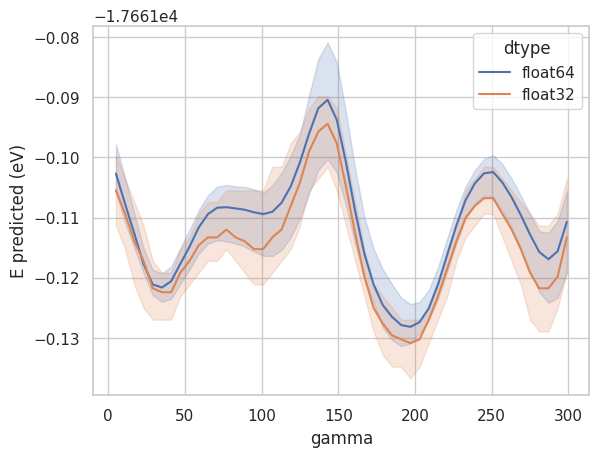

In [17]:
def minmax(x):
  return x.min(), x.max()
  
sns.lineplot(data=slice_df, x="gamma", y="E predicted (eV)", hue="dtype", errorbar=minmax)

In [18]:
checkpoints = glob("checkpoints/model_fp64_ls-1000_run*.model") + glob("checkpoints/model_ls-1000_run*.model")
slice_df = pd.concat([eval_slice(c) for c in checkpoints])
slice_df.head()

100%|██████████| 2/2 [00:00<00:00,  4.27it/s]


,alpha,beta,gamma,E predicted (eV),seed,dtype,clip_grad,loss_scale
0,71.0,120.0,5.0,-17661.108020,285,float64,-1,1000.0
1,71.0,120.0,11.0,-17661.112856,285,float64,-1,1000.0
2,71.0,120.0,17.0,-17661.116754,285,float64,-1,1000.0
3,71.0,120.0,23.0,-17661.120596,285,float64,-1,1000.0
4,71.0,120.0,29.0,-17661.122938,285,float64,-1,1000.0


<Axes: xlabel='gamma', ylabel='E predicted (eV)'>

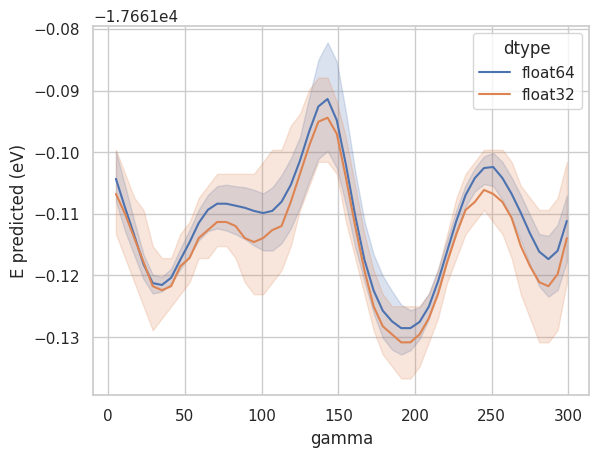

In [19]:
sns.lineplot(data=slice_df, x="gamma", y="E predicted (eV)", hue="dtype", errorbar=minmax)